全卷积网络先使用卷积神经网络抽取图像特征，然后通过1×1卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。 

因此，模型输出与输入图像的高和宽相同，且最终输出通道包含了该空间位置像素的类别预测。

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
# 使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征

pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

c:\ProgramData\anaconda3\envs\limu_deep\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\limu_deep\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [4]:
for i, layer in enumerate(net):
    print(f'第 {i + 1} 层: {layer.__class__.__name__}')
    print(layer)
    print('-' * 50)  # 分隔线

第 1 层: Conv2d
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
--------------------------------------------------
第 2 层: BatchNorm2d
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
--------------------------------------------------
第 3 层: ReLU
ReLU(inplace=True)
--------------------------------------------------
第 4 层: MaxPool2d
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
--------------------------------------------------
第 5 层: Sequential
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Con

In [5]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [6]:
num_classes = 21 # Pascal VOC2012数据集的类数（21类）

net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))

net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16))

In [7]:
# 双线性插值
# 线性插值相当于平滑过渡
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1), torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight


In [8]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1, bias=False)

conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))

img = torchvision.transforms.ToTensor()(d2l.Image.open('./catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()


input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


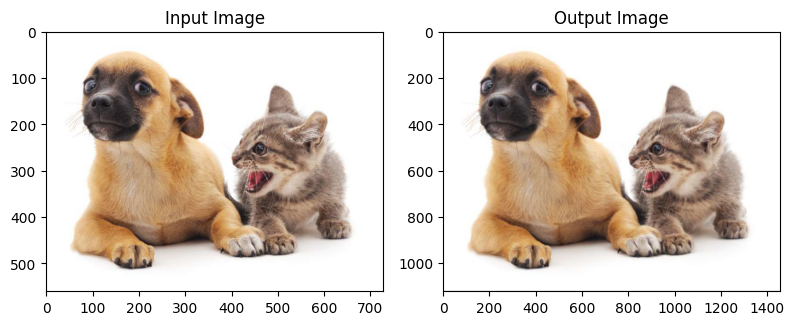

In [9]:
print('input image shape:', img.permute(1, 2, 0).shape)
print('output image shape:', out_img.shape)

# 创建一个包含两个子图的图形
fig, (ax1, ax2) = d2l.plt.subplots(1, 2, figsize=(8, 5))

# 在左侧显示输入图片
ax1.imshow(img.permute(1, 2, 0))
ax1.set_title('Input Image')

# 在右侧显示输出图片
ax2.imshow(out_img)
ax2.set_title('Output Image')

# 调整子图之间的间距
d2l.plt.tight_layout()

# 显示图形
d2l.plt.show()

In [10]:
net.transpose_conv.weight.data.copy_(bilinear_kernel(num_classes, num_classes, 64));

In [11]:
import os

def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images.

    Defined in :numref:`sec_semantic_segmentation`"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels.

    Defined in :numref:`sec_semantic_segmentation`"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices.

    Defined in :numref:`sec_semantic_segmentation`"""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images.

    Defined in :numref:`sec_semantic_segmentation`"""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset.

    Defined in :numref:`sec_semantic_segmentation`"""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset.

    Defined in :numref:`sec_semantic_segmentation`"""
    voc_dir = '../Semantic Segmentation/data/VOCdevkit/VOC2012'
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

In [12]:
batch_size, crop_size = 4, (320, 480)
train_iter, test_iter = load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


In [ ]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
print(devices)
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

[device(type='cuda', index=0)]


In [ ]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);